# Range simulation with PyBullet

Pybullet provides several tools for building complex physics simulations. It is used in many robotic research projects and it also provides a range sensor.

In this notebook, we will use the PyBullet package to build an scene and get some range sensings.

### Installation

- Create a conda environment. I have used the name *nbvr*.
- Activate the environment
```sh
source activate nbvr
```
- Install the PyBullet package. 
```sh
pip install pybullet
```
- Create a notebook or script

### 3D Models Installation

PyBullets uses the URFD format for representing the objects in the scene. URDF format may be difficult to understand at fist glance, therefore, we will import some models from the [Converted YCB] repository.

To install those models in your machine follow these instructions or check their latest release.

- Go to your projects folder and clone their repo
```sh
git clone https://github.com/eleramp/pybullet-object-models.git
pip install -e pybullet-object-models/
```


[Converted YCB]: <https://github.com/eleramp/pybullet-object-models>

### Start coding!

In [1]:
# Import libraries
import numpy as np
import matplotlib.pyplot as plt
import os
import math

import pybullet as pb 
import pybullet_data

from pybullet_object_models import ycb_objects

In [2]:
# Start the pybullet server
physicsClient = pb.connect(pb.GUI)
pb.resetDebugVisualizerCamera(3, 90, -30, [0.0, -0.0, -0.0])
pb.setTimeStep(1 / 240.)

In [3]:
# Insert a plane in the environment
pb.setAdditionalSearchPath(pybullet_data.getDataPath())
planeId = pb.loadURDF('plane.urdf')

In [4]:
# Insert some objects
flags = pb.URDF_USE_INERTIA_FROM_FILE

n_objects = 30
offset = 0.2
for i in range(n_objects):
    z_pos = 0 + i*offset
    obj_id = pb.loadURDF(os.path.join(ycb_objects.getDataPath(), 'YcbBanana', "model.urdf"), [0, 0.0, z_pos], flags=flags)


In [5]:
pb.setGravity(0, 0, -9.8)

In [6]:
# Start simulation
pb.setRealTimeSimulation(1)

In [7]:
# Define a camera view matrix
camPos = [0, 0, 2]
camTarget = [0, 0, 0]
camUp = [0, 1, 0]
viewMatrix = pb.computeViewMatrix(
    cameraEyePosition = camPos,
    cameraTargetPosition = camTarget,
    cameraUpVector=camUp)

In [8]:
# Define projection matrix
nearVal = 0.01
farVal = 5.1

projectionMatrix = pb.computeProjectionMatrixFOV(
    fov=30.0,
    aspect=1.0,
    nearVal=nearVal,
    farVal=farVal)

### Get depth image

depthImg = depth buffer. Bullet uses OpenGL to render, and the convention is non-linear z-buffer. See https://stackoverflow.com/questions/6652253/getting-the-true-z-value-from-the-depth-buffer

far=1000.//depends on projection matrix, this is default
near=0.01//depends on projection matrix
depth = far * near / (far - (far - near) * depthImg)//depthImg is the depth from Bullet 'getCameraImage'


In [9]:
# Get an image
imgW, imgH, rgbImg, depthImg, segImg = pb.getCameraImage(
    width=128, 
    height=128,
    viewMatrix=viewMatrix,
    projectionMatrix=projectionMatrix,
    renderer=pb.ER_BULLET_HARDWARE_OPENGL
)

In [10]:
print("rgbBuffer.shape=", rgbImg.shape)
print("depthBuffer.shape=", depthImg.shape)

rgbBuffer.shape= (128, 128, 4)
depthBuffer.shape= (128, 128)


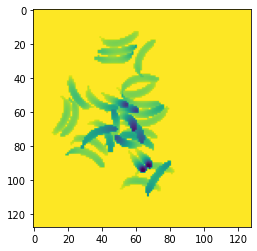

In [11]:
# Display the Buffer image
plt.imshow(depthImg)

## Convert range to depth

In [12]:
def getDepth(z_n, zNear, zFar):
    z_n = 2.0 * z_n - 1.0;
    z_e = 2.0 * zNear * zFar / (zFar + zNear - z_n * (zFar - zNear))
    return z_e

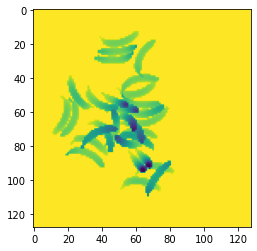

In [13]:
stepX = 1
stepY = 1
realDepthImg = depthImg.copy()
for w in range(0, imgW, stepX):
    for h in range(0, imgH, stepY):
        realDepthImg[w][h] = getDepth(depthImg[w][h],nearVal,farVal)
        
plt.imshow(realDepthImg)

## Convert depthImg to Point Cloud

Code based on: https://stackoverflow.com/questions/59128880/getting-world-coordinates-from-opengl-depth-buffer

In [1]:

stepX = 1
stepY = 1        
pointCloud = np.empty([np.int32(imgH/stepY), np.int32(imgW/stepX), 4])

projectionMatrix = np.asarray(projectionMatrix).reshape([4,4],order='F')

viewMatrix = np.asarray(viewMatrix).reshape([4,4],order='F')

tran_pix_world = np.linalg.inv(np.matmul(projectionMatrix, viewMatrix))

for h in range(0, imgH, stepY):
    for w in range(0, imgW, stepX):
            x = (2*w - imgW)/imgW
            y = -(2*h - imgH)/imgH  # be careful！ deepth and its corresponding position
            # duda
            z = 2*depthImg[h,w] - 1
            #z = realDepthImg[h,w]
            pixPos = np.asarray([x, y, z, 1])
            #print(pixPos)
            position = np.matmul(tran_pix_world, pixPos)
            pointCloud[np.int32(h/stepY), np.int32(w/stepX), :] = position / position[3]
            
print(pointCloud.shape)

NameError: name 'np' is not defined

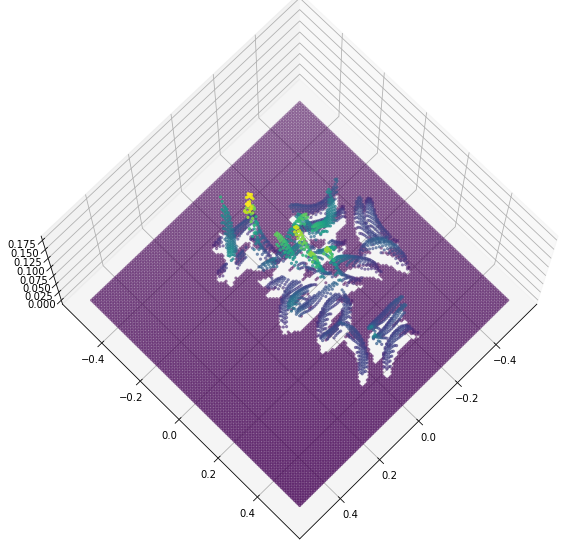

In [15]:
# Creating 3D figure
xs = []
ys = []
zs = []

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

ax = plt.axes(projection='3d')

for h in range(0, imgH, stepY):
    for w in range(0, imgW, stepX):
        [x,y,z,_] = pointCloud[h,w]
        #print(pointCloud[h,w])
        xs.append(x)
        ys.append(y)
        zs.append(z)
        

ax.scatter(xs, ys, zs, c=zs, marker='.');
ax.view_init(75, 45)
plt.draw()
